In [ ]:
"""All TODO"""
# TODO: Add ground-truth data stations as different shape / colour nodes
# TODO: Plot all timeseries data in full, knock out two unacceptable ones and then plot omitting suspect and unchecked data
# TODO: interpolate missing data (with quick missingness checks - check DEVUL assignment feedback on this)
# TODO: GNN iteration 1 inc. shallow aquifer then test metrics to decide on inclusion (RMSE, MSE etc). See Notion: Project Data > Preprocessing Steps > 0b. > Full Notes (Page)

Imports

In [ ]:
import os
import ast
import folium
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyproj import Transformer
from shapely.geometry import box
from datetime import datetime, timedelta

In [ ]:
# print("pyproj:", pyproj.__version__)
# print("shapely:", shapely.__version__)

Mesh building function definition

Create mesh using input shape file

Folium interactive map (open from html file for full view). Catchment boundary currently interactive.

Basic matplotlib map

Import Station Data using DEFRA API

**API Documentation notes:**

1. The API calls that return readings data have a soft limit of 100,000 rows per-call which can be overridden by setting a _limit parameter. There is a hard limit of 2,000,000 rows, which cannot be overridden.
2. The primary identifier for most stations uses a GUID style identifier called an SUID. These are used in the URL for the station and given as the value of the notation property in the station metadata.  
    a. Wiski identifier (wiskiID) is also available for my subset of stations and data type  
3. All monitoring stations can be filtered by name, location and other parameters. See https://environment.data.gov.uk/hydrology/doc/reference#stations-summary for full metadata details

Convert raw csv files into catchment dict

Remove outliers and resample gwl to daily resolution

In [ ]:
def remove_outliers(df, z_thresh=4):
    # Ensure numeric
    df = df.copy()
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    
    # Z-score outlier removal
    z = (df['value'] - df['value'].mean()) / df['value'].std()
    df.loc[z.abs() > z_thresh, 'value'] = pd.NA
    return df

def resample_daily_average(df):
    df = df.copy()
    df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')
    df = df.dropna(subset=['dateTime'])
    df = df.sort_values('dateTime')

    # Set index for resampling
    df = df.set_index('dateTime')
    
    # Define aggregation functions
    agg_funcs = {
        'station_name': 'first',
        'date': 'first',
        'value': 'mean',
        'quality': lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA,
        'measure': 'first'
    }
    
    # Resample and aggregate
    daily_df = df.resample('1D').agg(agg_funcs).reset_index()
    
    return daily_df

# Clean data and resample to days
daily_time_series = {}
for station, df in time_series_data.items():
    clean_df = remove_outliers(df)
    daily_avg_df = resample_daily_average(clean_df)
    daily_time_series[station] = daily_avg_df

Plot initial cleaned data as time series line graphs to begin to understand the data

In [ ]:
def plot_timeseries(time_series_raw, station_name):
    """Resusable matplotlib time series plot"""
    fig, ax = plt.subplots(figsize=(15, 4))
    time_series_raw['dateTime'] = pd.to_datetime(time_series_raw['dateTime'], errors='coerce')

    # Define fixed colours for each quality level
    quality_colors = {
        'Good': '#70955F',
        'Estimated': '#549EB1',
        'Suspect': '#DF6607',
        'Unchecked': '#e89c1d',
        'Missing': '#9c9acd'
    }
    
    # Plot using qualities score as legend
    for quality, color in quality_colors.items():
        temp = time_series_raw.copy()
        temp['value'] = temp['value'].where(temp['quality'] == quality, pd.NA)
        ax.plot(temp['dateTime'], temp['value'], label=quality, color=color, alpha=0.8)

    # Apply auto locators and formatters to clean up ticks
    locator = mdates.AutoDateLocator(minticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()
    
    ax.set_title(f'{station_name} Groundwater Level 2014-2025')
    ax.set_xlabel('Date')
    ax.set_ylabel('Groundwater Level (mAOD)')
    ax.grid()
    ax.legend(title="Quality", loc="center left", bbox_to_anchor=(1.01, 0.5))
    
    plt.tight_layout()
    plt.savefig(f"figures/eden_catchment/raw_timeseries_plots/{station_name}_raw_plot_.png", dpi=300)
    plt.show()

# Plot data at a daily resolution
for station in daily_time_series:
    print(f'Columns for {station}:\n    {daily_time_series[station].columns}\n    Total Entries: {len(daily_time_series[station])}\n')
    plot_timeseries(daily_time_series[station], station)

Create geodataframes for stations:

In [ ]:
# from shapely.geometry import Point

# # Convert to GeoDataFrame using WGS84 (lat/lon)
# stations_gdf = gpd.GeoDataFrame(
#     stations_df,
#     geometry=gpd.points_from_xy(stations_df['lon'], stations_df['lat']),
#     crs="EPSG:4326"
# )

# # Reproject to match mesh CRS (British National Grid)
# stations_gdf = stations_gdf.to_crs("EPSG:27700")


Snap stations to nearest mesh node

In [ ]:
# from shapely.ops import nearest_points
# import shapely.geometry

# # Rebuild mesh index
# mesh_sindex = mesh_nodes_gdf.sindex

# def find_nearest_node(station_point):
#     # This is the key fix: pass geometry directly, not as a list
#     nearest_idx = list(mesh_sindex.nearest(station_point, return_all=False))[0]

#     nearest_row = mesh_nodes_gdf.iloc[nearest_idx]
#     nearest_geom = nearest_row.geometry

#     # Ensure it's a proper Shapely Point
#     if hasattr(nearest_geom, '__geo_interface__') and not isinstance(nearest_geom, shapely.geometry.base.BaseGeometry):
#         nearest_geom = shapely.geometry.shape(nearest_geom)

#     return pd.Series({
#         'nearest_node_id': int(nearest_row['node_id']),
#         'nearest_geometry': nearest_geom
#     })


# # Apply snapping
# stations_gdf[['nearest_node_id', 'nearest_geometry']] = stations_gdf.geometry.apply(find_nearest_node)
# stations_gdf = stations_gdf.set_geometry('nearest_geometry').to_crs("EPSG:4326")
# stations_gdf['lat'] = stations_gdf.geometry.y
# stations_gdf['lon'] = stations_gdf.geometry.x


In [ ]:
# print(stations_gdf[['station_id', 'nearest_node_id', 'lat', 'lon']])

In [ ]:
# import folium

# # Recreate map centered on catchment
# map_center = [mesh_nodes_gdf['lat'].mean(), mesh_nodes_gdf['lon'].mean()]
# map = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron")

# # Add snapped station locations
# for _, row in stations_gdf.iterrows():
#     folium.Marker(
#         location=[row['lat'], row['lon']],
#         popup=f"{row['station_id']} → Node {row['nearest_node_id']}"
#     ).add_to(map)

# # Optionally add mesh nodes
# for _, row in mesh_nodes_gdf.iterrows():
#     folium.CircleMarker(
#         location=[row['lat'], row['lon']],
#         radius=1,
#         color="#354c7c",
#         fill=True,
#         fill_opacity=0.6
#     ).add_to(map)

# # Save
# map.save("figures/station_to_mesh_snapping.html")
# map


INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml

Testing 4...


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/1075041552.py:133: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [206.56-222.77].
Max value before IQR cleaning: 217.413
INFO - Total 78 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/ac9140ea-d518-4e81-8744-224f234a829e-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


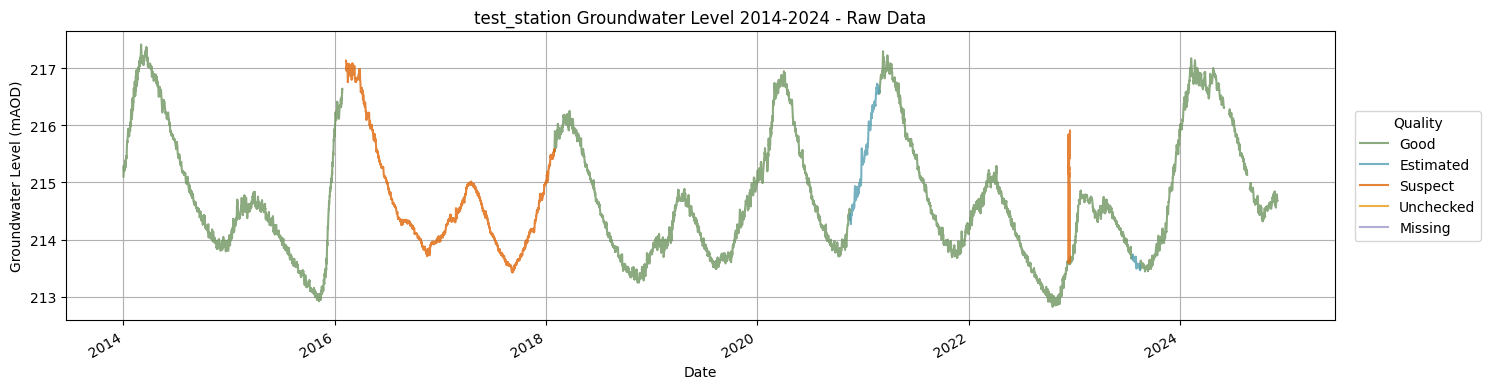

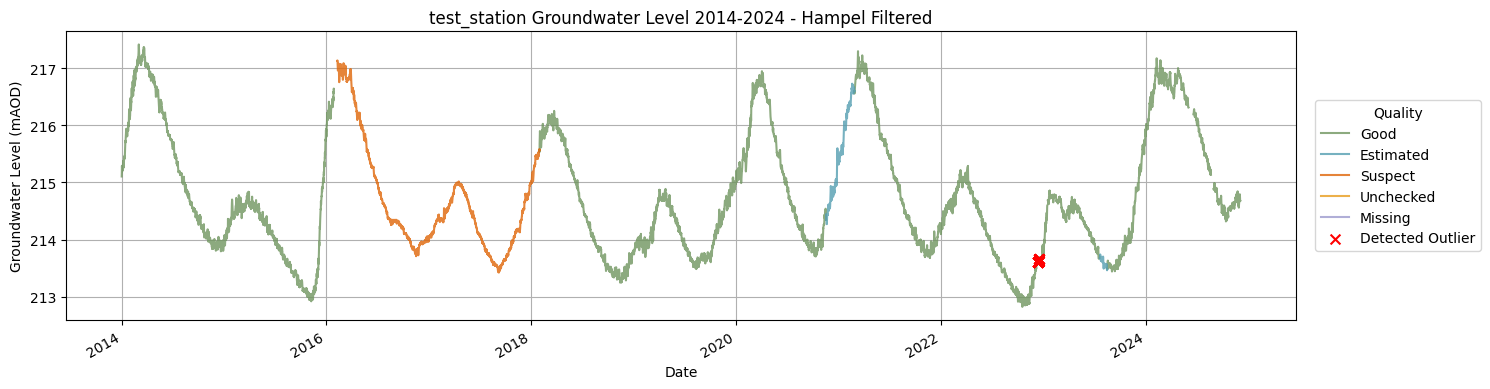


Testing 7...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [39.54-42.73].
Max value before IQR cleaning: 42.902
INFO - Station test_station: Identified 1 points outside IQR-based range and set to NaN.


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/1075041552.py:133: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Total 10 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/dbdc1aca-14eb-45e8-beb5-204d5e5f9133-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


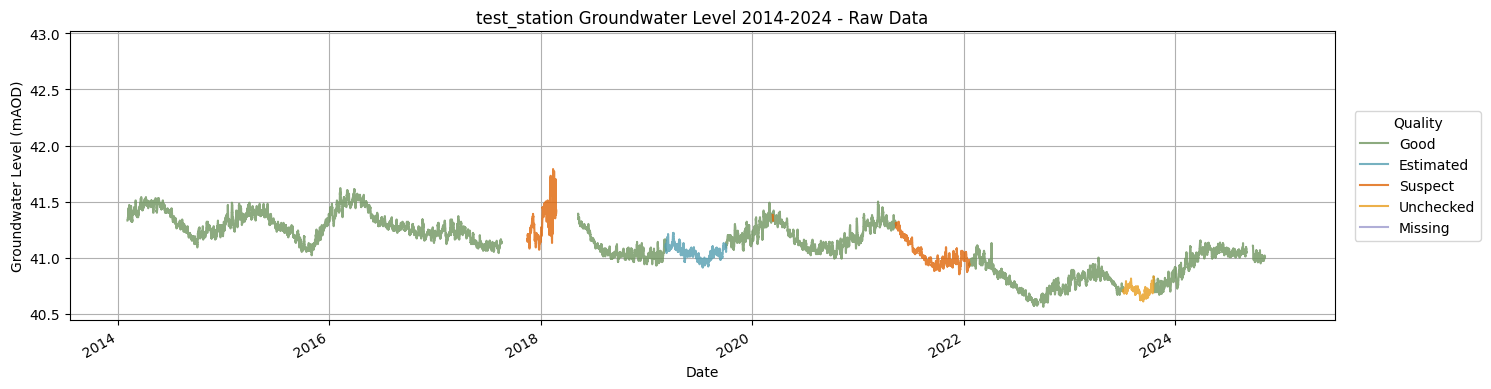

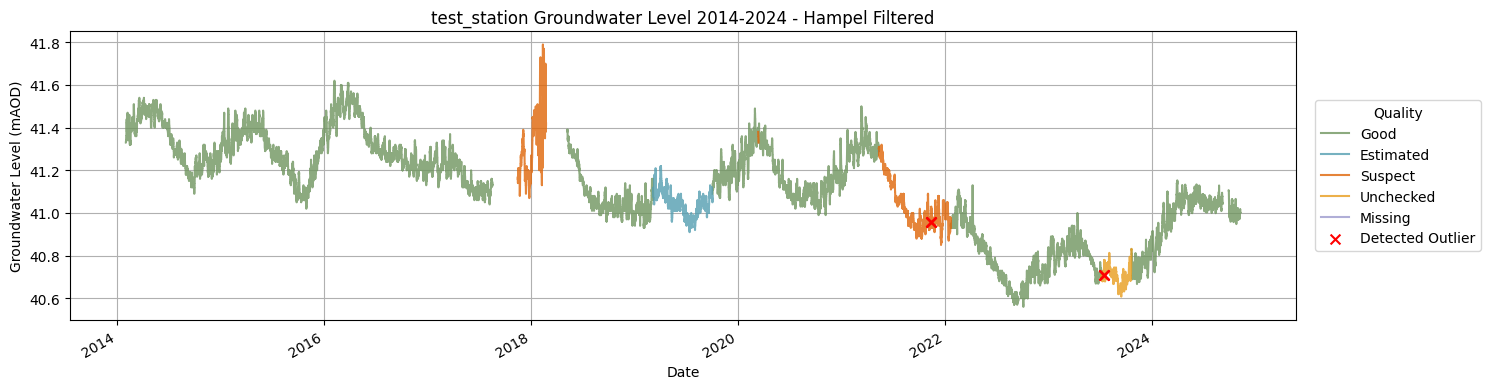


Testing 8...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [103.90-109.59].
Max value before IQR cleaning: 159.5
INFO - Station test_station: Identified 46 points outside IQR-based range and set to NaN.


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/1075041552.py:133: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Total 23 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/56b2785b-5888-4bdd-aead-fdbb07a24a0d-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


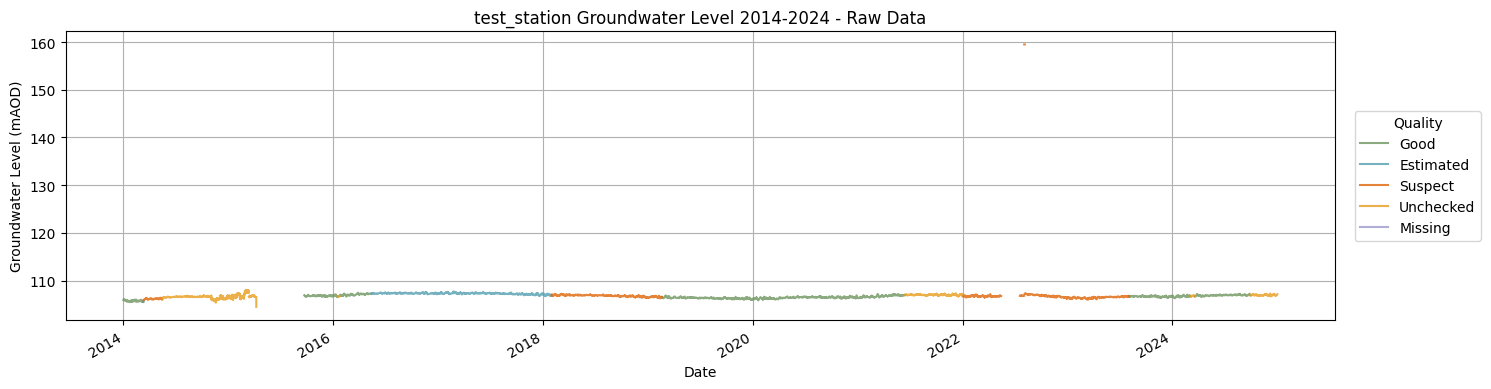

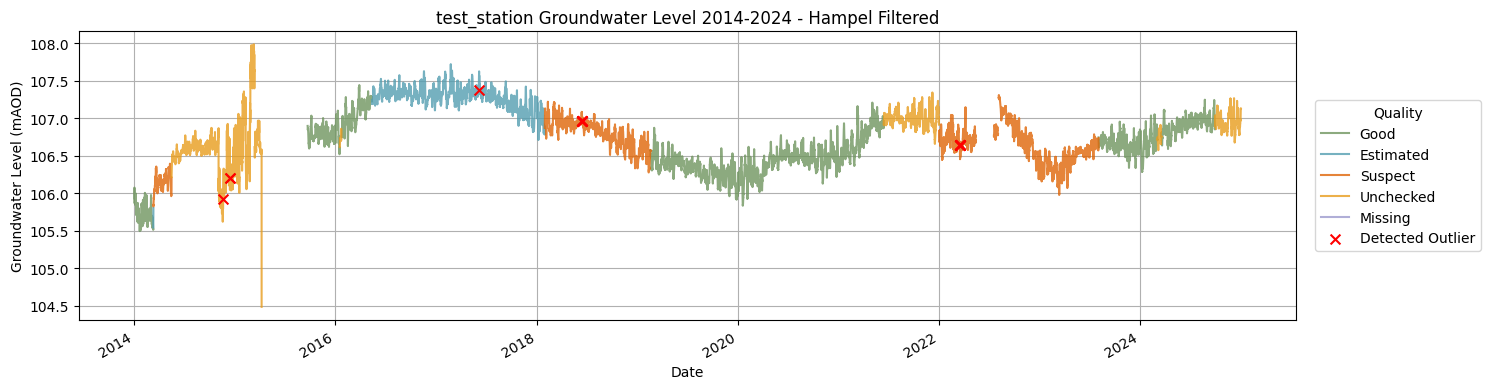


Testing 10...


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/1075041552.py:133: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [85.33-89.06].
Max value before IQR cleaning: 91.654
INFO - Station test_station: Identified 1174 points outside IQR-based range and set to NaN.
INFO - Total 48 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/67826ad1-09ba-4158-bf4e-01810b6be61c-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


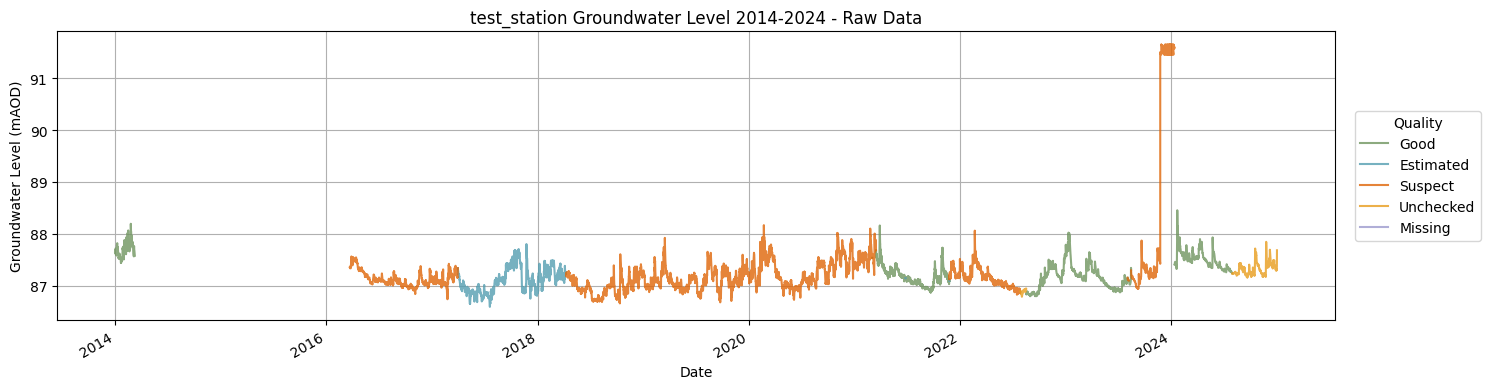

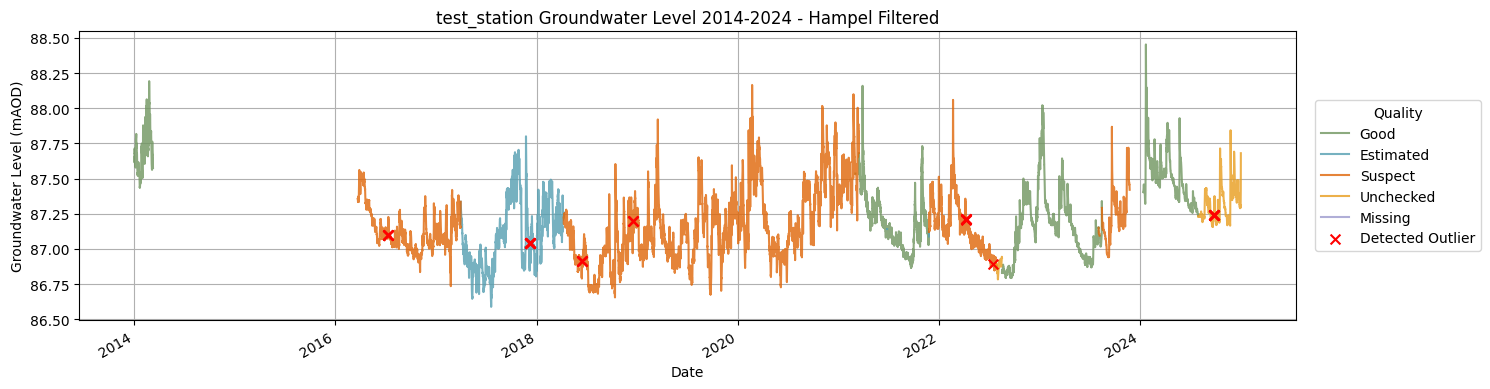


Testing 14...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [36.94-41.40].
Max value before IQR cleaning: 40.016
INFO - Total 10 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/87b10a0c-db0d-41c8-9a68-ef7330b3f518-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


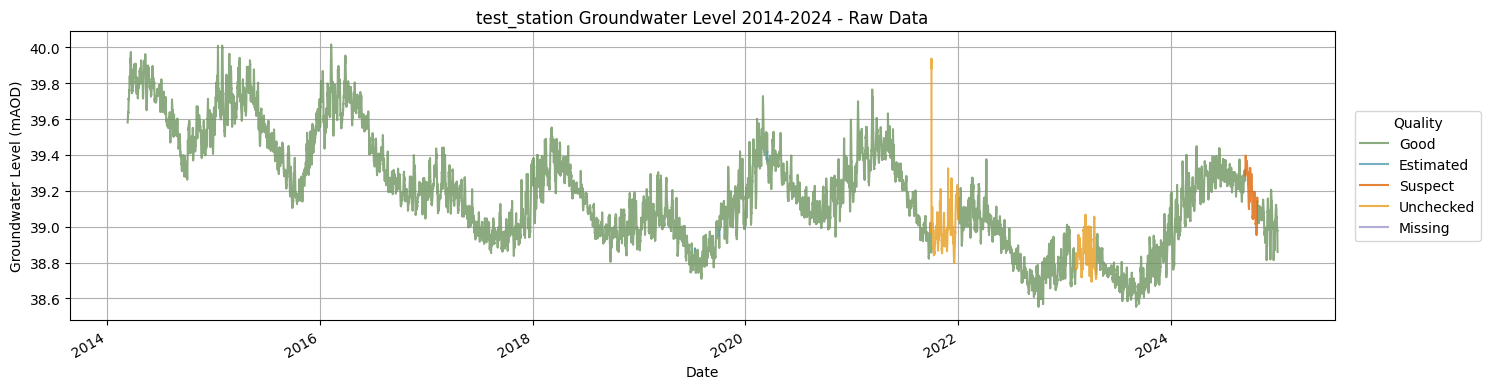

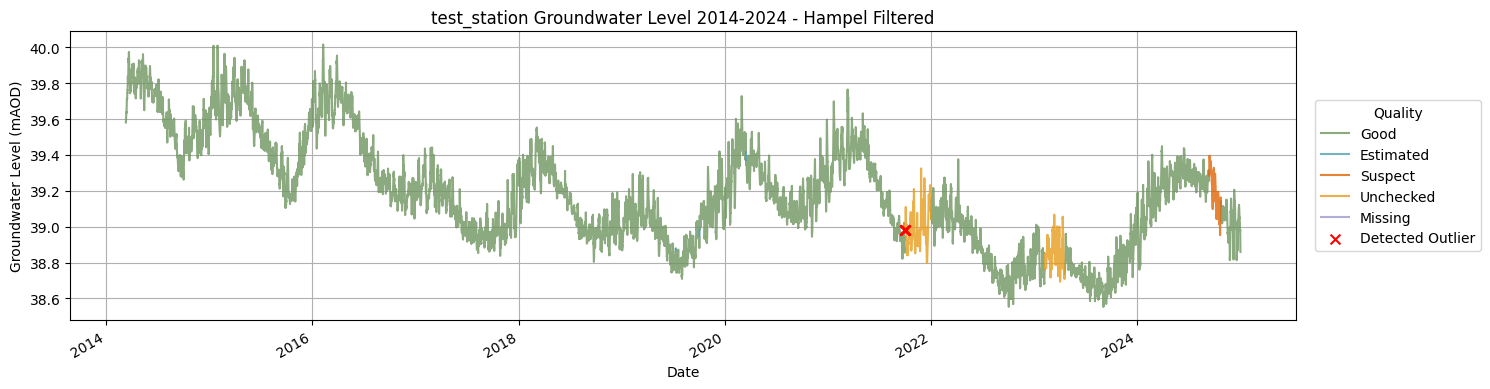


Testing 9...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [109.03-111.32].
Max value before IQR cleaning: 111.658
INFO - Station test_station: Identified 49 points outside IQR-based range and set to NaN.
INFO - Total 21 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/b7735057-e074-4399-8148-0c4aa521ea10_NY52_25-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


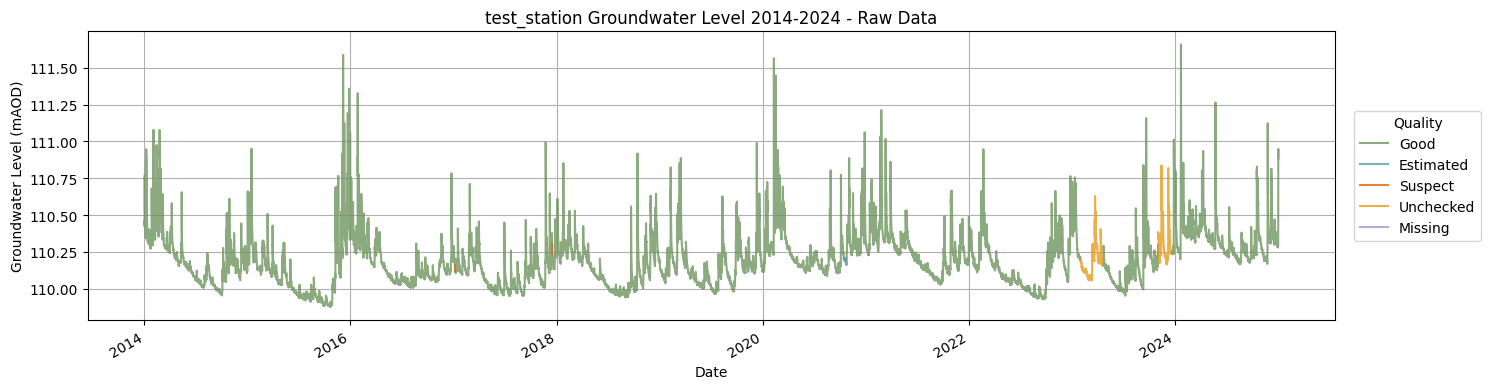

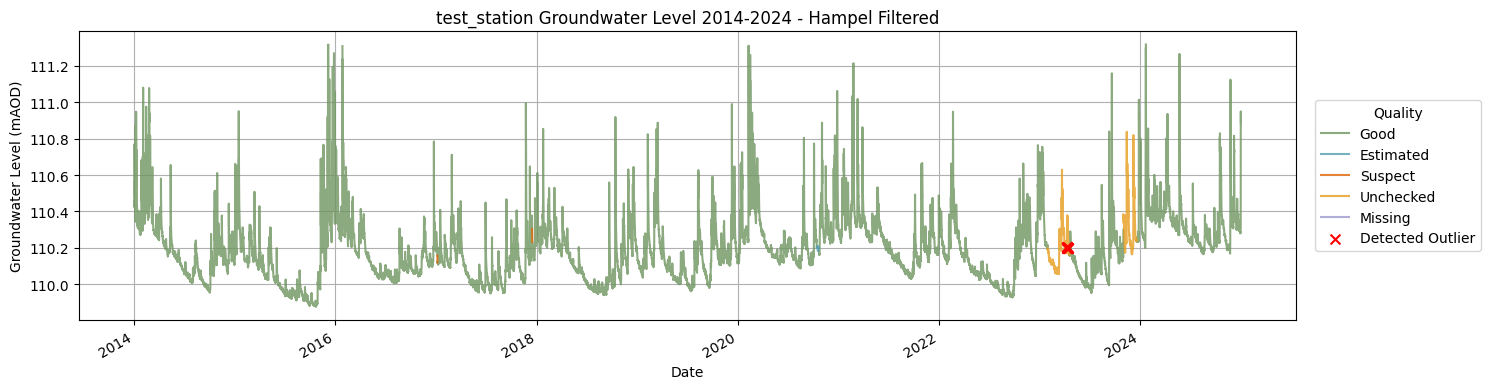

In [26]:
import os
import sys
import logging
import numpy as np
import pandas as pd
from hampel import hampel # This refers to the 'hampel' library's function
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from src.utils.config_loader import load_project_config

logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s - %(message)s', # Uncomment for short logging
    # format='%(asctime)s - %(levelname)s - %(name)s - %(message)s', # Uncomment for full logging
    handlers=[logging.StreamHandler(sys.stdout)]
)

logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")

def plot_timeseries(time_series_df, station_name, outlier_mask=None, plot_title_suffix=""):

    fig, ax = plt.subplots(figsize=(15, 4))

    # Ensure dateTime is datetime type and value is numeric
    time_series_df['dateTime'] = pd.to_datetime(time_series_df['dateTime'], errors='coerce')

    # Make a copy to avoid SettingWithCopyWarning if original_df is a slice
    df_to_plot = time_series_df.copy()
    df_to_plot['value'] = pd.to_numeric(df_to_plot['value'], errors='coerce')

    # Define fixed colours for each quality level
    quality_colors = {
        'Good': '#70955F',
        'Estimated': '#549EB1',
        'Suspect': '#DF6607',
        'Unchecked': '#e89c1d',
        'Missing': '#9c9acd'
    }

    # Plot using qualities score as legend
    for quality, color in quality_colors.items():
        temp = df_to_plot.copy()
        temp['value'] = temp['value'].where(temp['quality'] == quality, np.nan)
        ax.plot(temp['dateTime'], temp['value'], label=quality, color=color, alpha=0.8, linewidth=1.5)

    # If an outlier mask is provided, plot the outliers

    if outlier_mask is not None and not outlier_mask.empty:
        # Filter the ORIGINAL DataFrame to get just the outlier points' original values
        # This is crucial for plotting the 'before' value of the outlier
        original_values_for_outliers = time_series_df['value'][outlier_mask]
        original_datetimes_for_outliers = time_series_df['dateTime'][outlier_mask]

        # Plot markers for the detected outliers
        ax.scatter(
            original_datetimes_for_outliers,
            original_values_for_outliers,
            color='red',
            marker='x',
            s=50, # size of the marker
            label='Detected Outlier',
            zorder=5 # Ensures markers are on top
        )

    # Apply auto locators and formatters to clean up ticks
    locator = mdates.AutoDateLocator(minticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()

    ax.set_title(f'{station_name} Groundwater Level 2014-2024{plot_title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Groundwater Level (mAOD)')
    ax.grid(True)
    ax.legend(title="Quality", loc="center left", bbox_to_anchor=(1.01, 0.5))

    plt.tight_layout()
    # plt.savefig(f"figures/eden_catchment/raw_timeseries_plots/{station_name}_raw_plot_.png", dpi=300)

    return plt

def initial_threshold_cleaning(df: pd.DataFrame, station_name: str, iqr_multiplier: float = 5.0):
    """
    Performs initial data type conversion, drops unparseable rows,
    and applies a hard realistic range check based on IQR.
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    df_cleaned = df.copy()
    
    # --- Dynamic Hard Range Check using IQR ---
    clean_values = df_cleaned['value'].dropna()
    
    if not clean_values.empty:
        Q1 = clean_values.quantile(0.25)
        Q3 = clean_values.quantile(0.75)
        IQR = Q3 - Q1
        
        # Define limits as Q1 - (iqr_multiplier * IQR) and Q3 + (iqr_multiplier * IQR)
        # Using 3.0 for iqr_multiplier is common for "extreme" outliers
        lower_bound_iqr = Q1 - (iqr_multiplier * IQR)
        upper_bound_iqr = Q3 + (iqr_multiplier * IQR)
        
        logger.info(f"Station {station_name}: Automatically determined hard limits based on IQR (multiplier={iqr_multiplier}): [{lower_bound_iqr:.2f}-{upper_bound_iqr:.2f}].")

        print("Max value before IQR cleaning:", df_cleaned['value'].max())

        # Identify values outside this dynamic range
        out_of_range_mask = (df_cleaned['value'] < lower_bound_iqr) | \
                            (df_cleaned['value'] > upper_bound_iqr)
        
        num_out_of_range = out_of_range_mask.sum()
        if num_out_of_range > 0:
            logger.info(f"Station {station_name}: Identified {num_out_of_range} points outside IQR-based range and set to NaN.")
            df_cleaned.loc[out_of_range_mask, 'value'] = np.nan 
    else:
        logger.warning(f"Station {station_name}: No valid 'value' data found for IQR calculation. Skipping hard range check.")
        
    return df_cleaned


# --- Main Execution Block ---
test_dir = "data/01_raw/eden/gwl_stations/API_data/copy/"
to_test = [4, 7, 8, 10, 14, 9]

for n in to_test:
    print(f'\nTesting {n}...')
    
    test_path = test_dir + os.listdir(test_dir)[n]
    test_csv = pd.read_csv(test_path)

    # Ensure 'value' column is numeric and replace any non-numeric missing indicators with NaN
    test_csv['value'] = pd.to_numeric(test_csv['value'], errors='coerce')

    # Plot before Hampel outlier filtering
    before_plot = plot_timeseries(test_csv, "test_station", plot_title_suffix=" - Raw Data")

    # Apply initial threshold cleaning
    test_csv_cleaned = initial_threshold_cleaning(test_csv, "test_station", iqr_multiplier=5.0)
    # iqr_only_plot = plot_timeseries(test_csv_cleaned, "test_station", plot_title_suffix=" - After IQR Cleaning")

    # Store original values to later detect changes made by Hampel filter
    original_values = test_csv_cleaned['value'].copy()

    # Apply Hampel filter
    hampel_result = hampel(original_values, window_size=250, n_sigma=5.0)

    # Get the filtered data Series (which now has outliers replaced by medians)
    filtered_values = hampel_result.filtered_data

    # Determine the outlier mask by comparing original to filtered data
    outlier_mask = ~np.isclose(original_values, filtered_values, equal_nan=True)

    # Refine the mask to only include points that were originally valid and have changed
    outlier_mask = outlier_mask & original_values.notna()

    # Create a mask for 'Good' quality points.
    good_quality_mask = (test_csv['quality'] == 'Good')
    final_outlier_mask = outlier_mask & (~good_quality_mask)

    # Create a new DataFrame for the 'after' plot with filtered values
    test_csv_filtered = test_csv_cleaned.copy()
    test_csv_filtered.loc[final_outlier_mask, 'value'] = filtered_values.loc[final_outlier_mask]

    # Log total number of replaced outliers
    total_replaced_outliers = final_outlier_mask.sum()
    logger.info(f"Total {total_replaced_outliers} outliers detected and replaced by Hampel filter in '{test_path}'.")

    # Pass the filtered DataFrame and the generated outlier_mask, to highlight replaced points in plot
    after_plot = plot_timeseries(test_csv_filtered, "test_station", outlier_mask=final_outlier_mask, plot_title_suffix=" - Hampel Filtered")

    plt.show()

# Remove if outside check + quality marked as suspect or unchecked (use 4, 7, 8, 10, 14 & NB: 9 may be an issue)
# First remove values outside a realistic range
# Basic rule: If quality = unchecked/suspect and more then 3IQR from spline average line then mark as outlier. If good/estimated quality then flag for checking.

INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml



Testing 4...


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/2270002532.py:132: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [206.56-222.77].
Max value before IQR cleaning: 217.413
INFO - Total 80 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/ac9140ea-d518-4e81-8744-224f234a829e-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


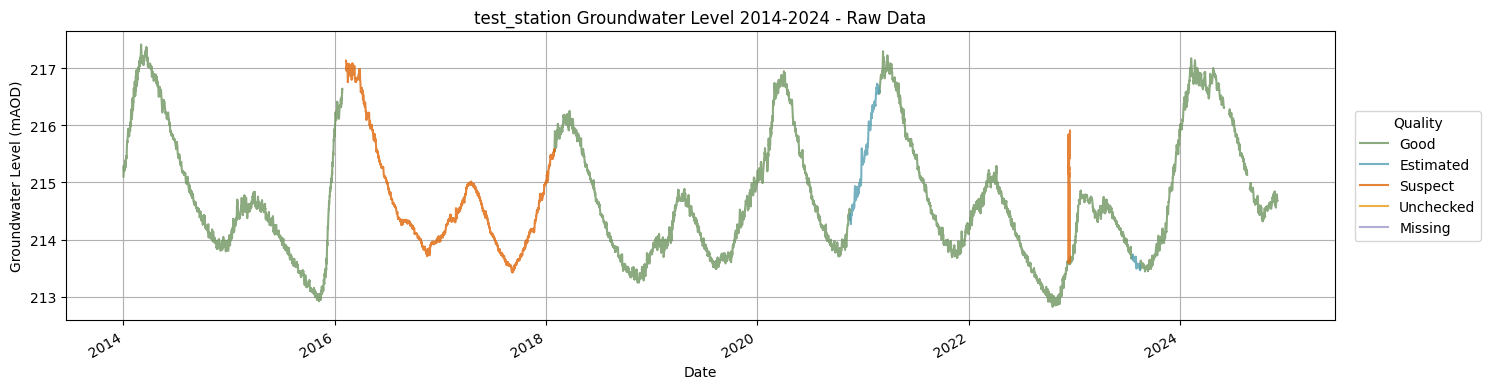

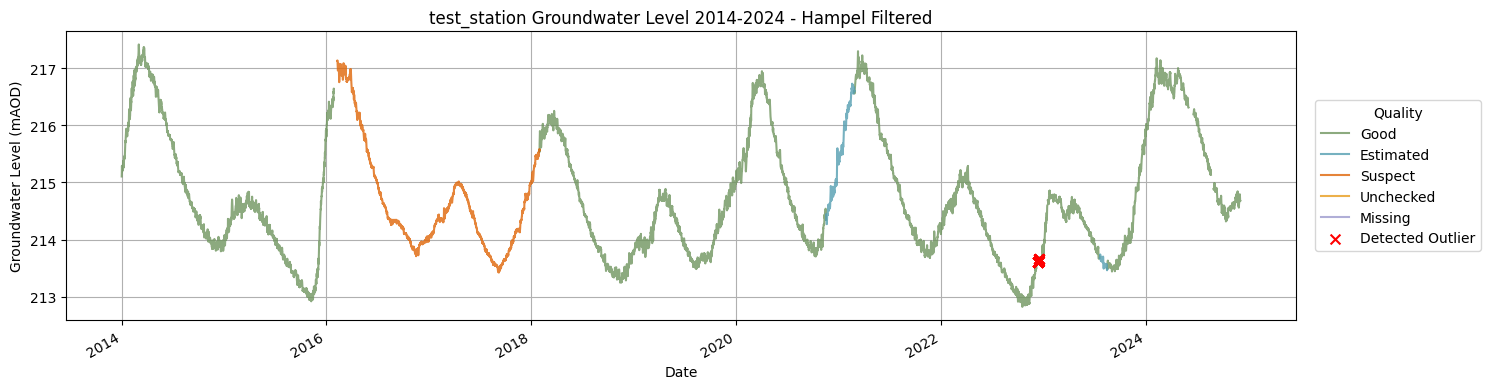


Testing 7...


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/2270002532.py:132: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [39.54-42.73].
Max value before IQR cleaning: 42.902
INFO - Station test_station: Identified 1 points outside IQR-based range and set to NaN.
INFO - Total 10 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/dbdc1aca-14eb-45e8-beb5-204d5e5f9133-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


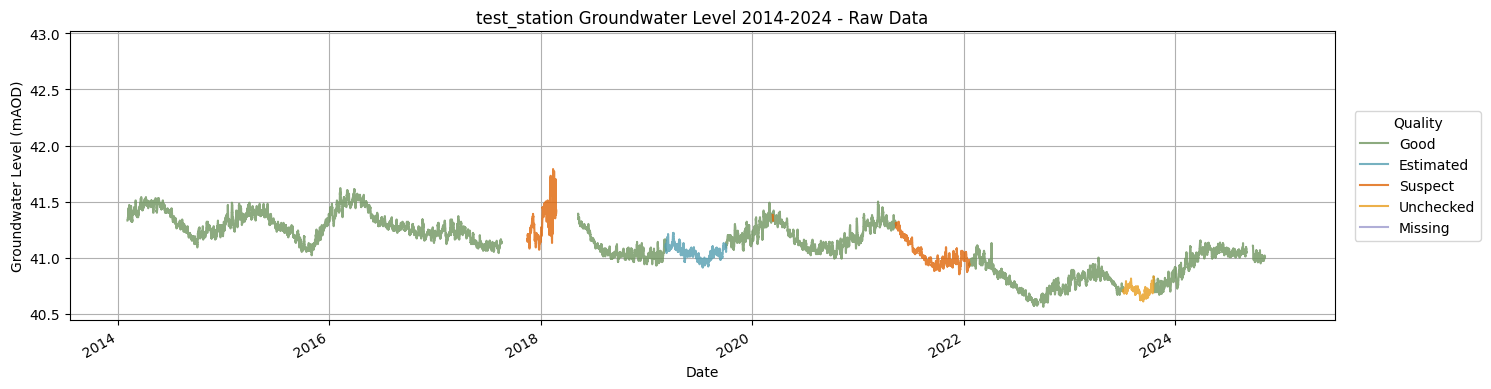

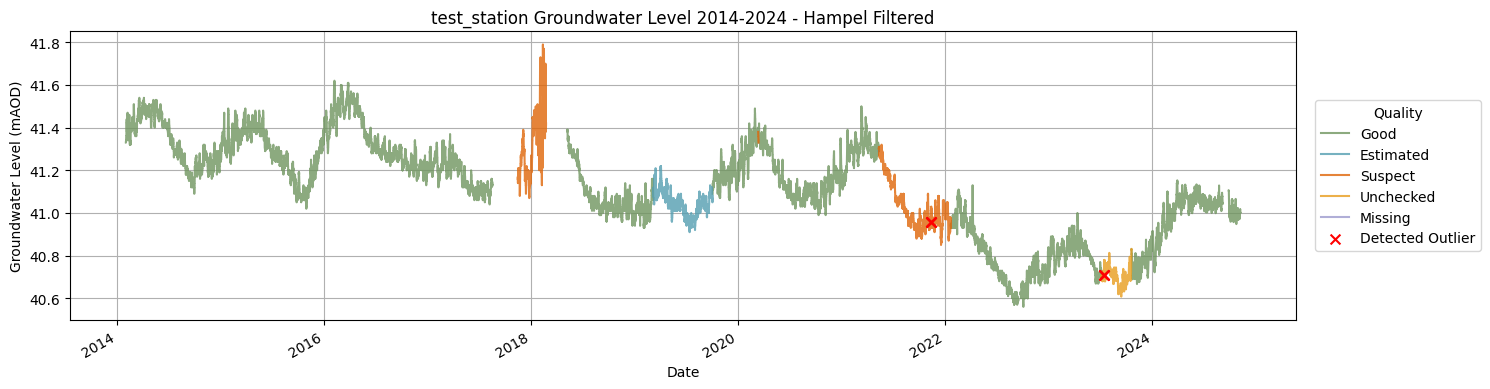


Testing 8...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [103.90-109.59].
Max value before IQR cleaning: 159.5
INFO - Station test_station: Identified 46 points outside IQR-based range and set to NaN.


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/2270002532.py:132: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Total 24 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/56b2785b-5888-4bdd-aead-fdbb07a24a0d-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


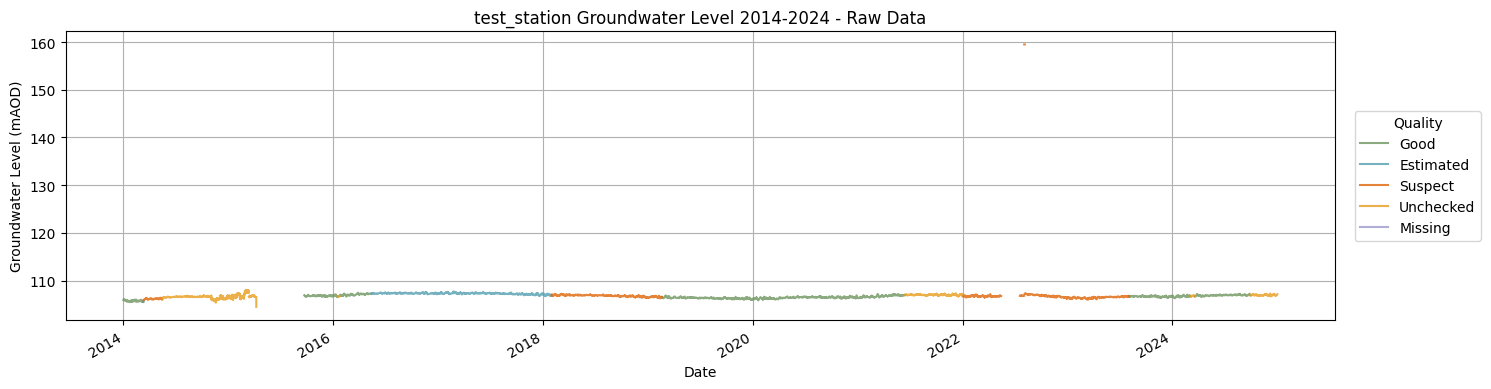

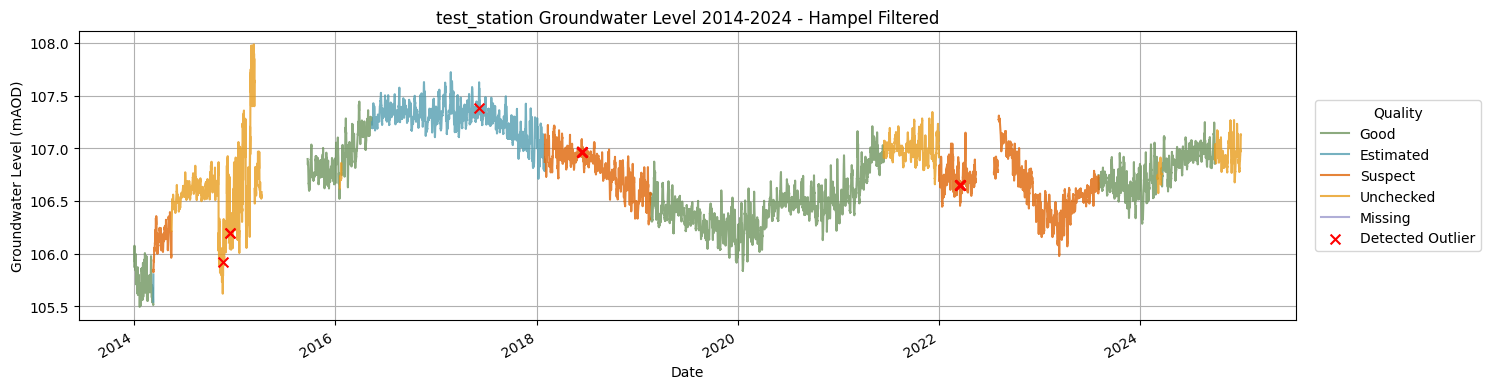


Testing 10...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [85.33-89.06].
Max value before IQR cleaning: 91.654
INFO - Station test_station: Identified 1174 points outside IQR-based range and set to NaN.


/var/folders/6z/nwg7g94j3rx7gn227ptyb7r40000gn/T/ipykernel_53485/2270002532.py:132: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_csv = pd.read_csv(test_path)


INFO - Total 50 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/67826ad1-09ba-4158-bf4e-01810b6be61c-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


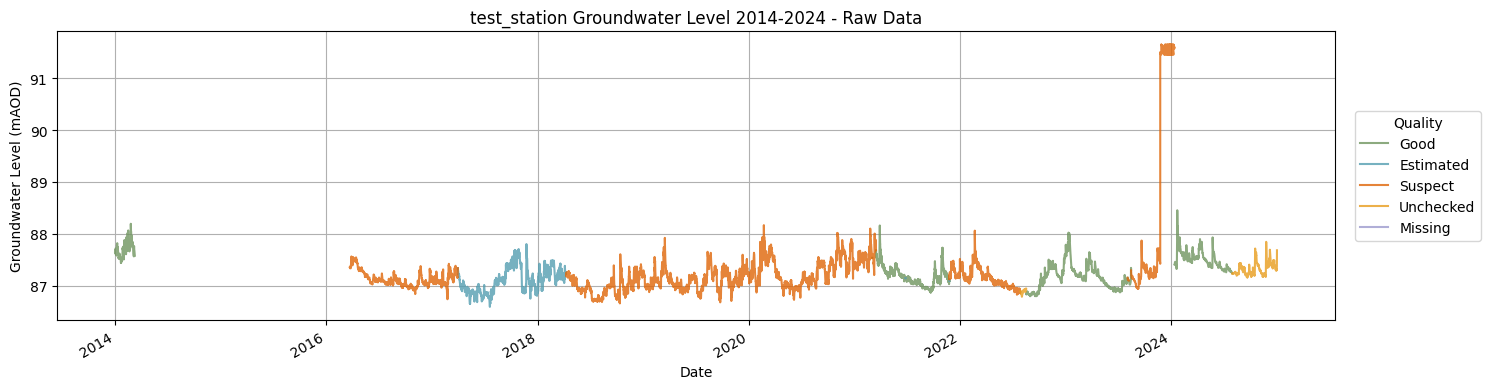

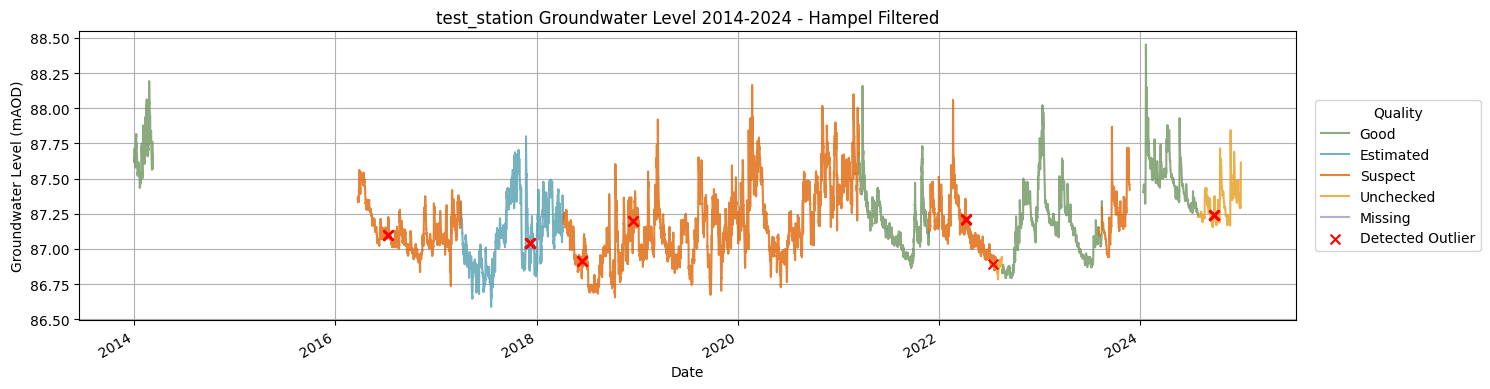


Testing 14...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [36.94-41.40].
Max value before IQR cleaning: 40.016
INFO - Total 10 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/87b10a0c-db0d-41c8-9a68-ef7330b3f518-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


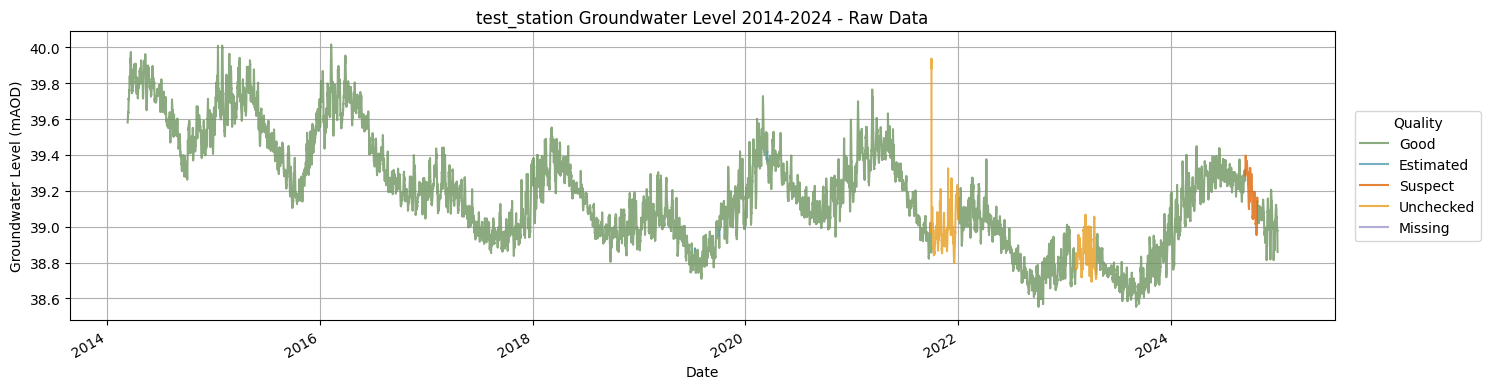

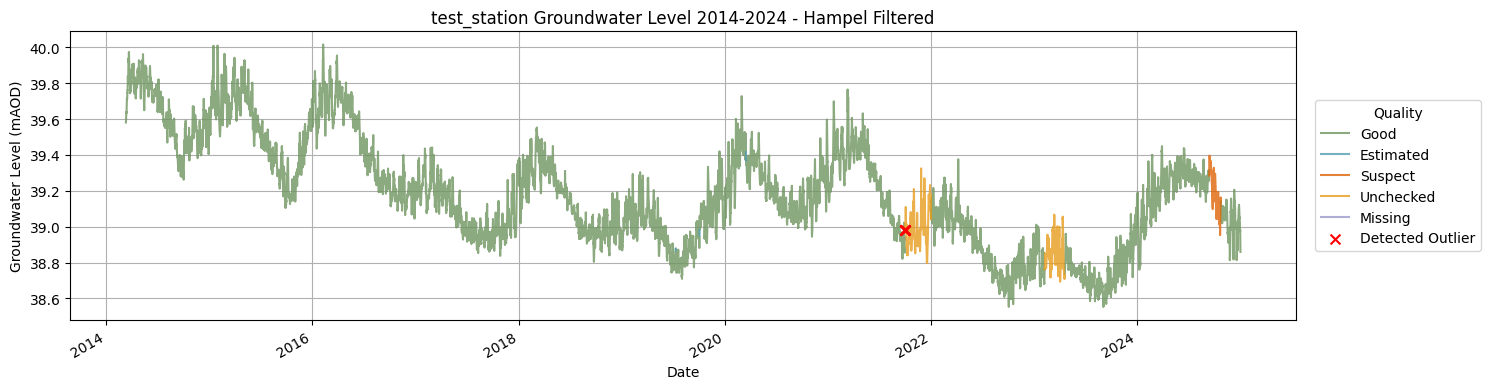


Testing 9...
INFO - Station test_station: Automatically determined hard limits based on IQR (multiplier=5.0): [109.03-111.32].
Max value before IQR cleaning: 111.658
INFO - Station test_station: Identified 49 points outside IQR-based range and set to NaN.
INFO - Total 21 outliers detected and replaced by Hampel filter in 'data/01_raw/eden/gwl_stations/API_data/copy/b7735057-e074-4399-8148-0c4aa521ea10_NY52_25-gw-logged-i-subdaily-mAOD-qualified_readings.csv'.


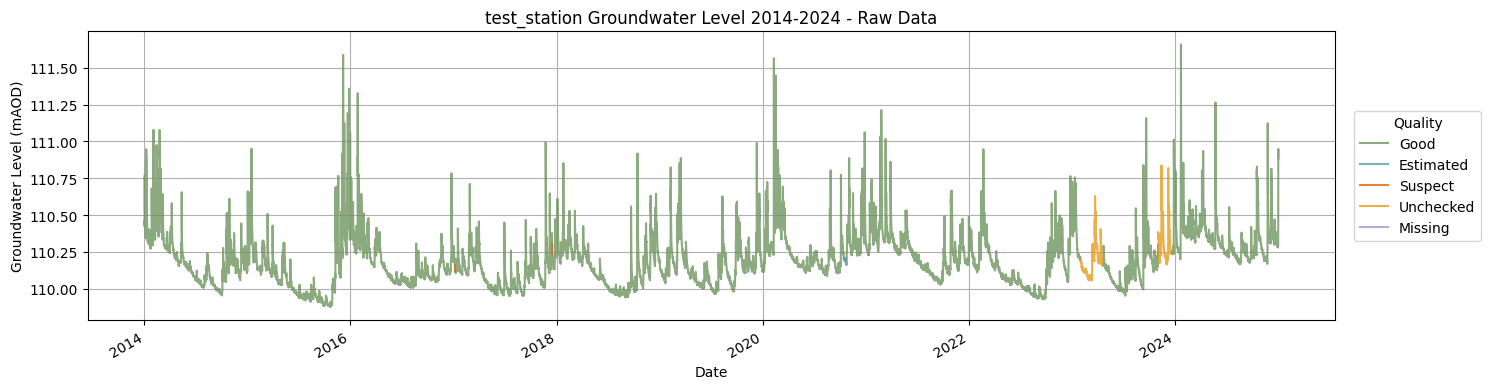

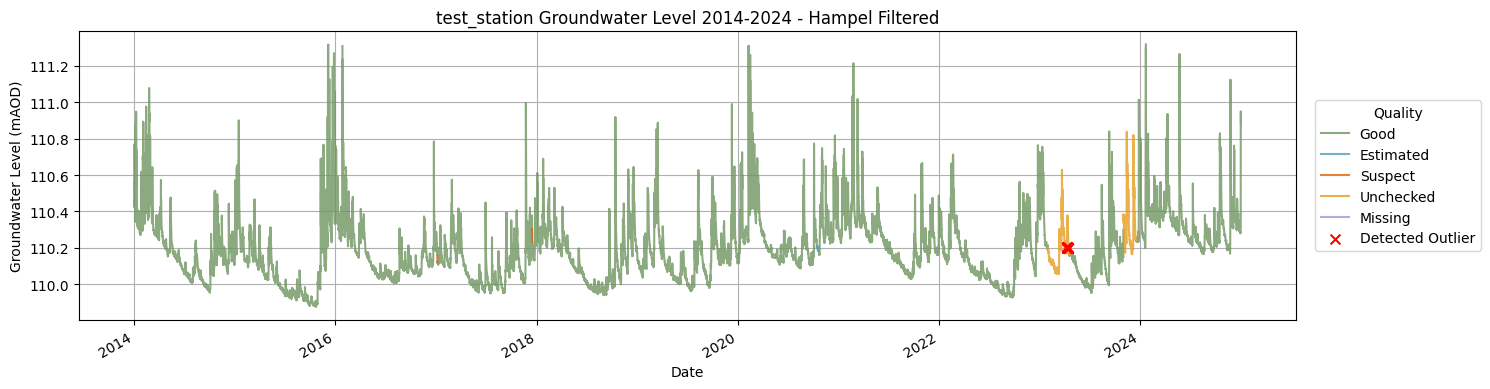

In [31]:
import os
import sys
import logging
import numpy as np
import pandas as pd
from hampel import hampel
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from src.utils.config_loader import load_project_config

logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s - %(message)s', # Uncomment for short logging
    # format='%(asctime)s - %(levelname)s - %(name)s - %(message)s', # Uncomment for full logging
    handlers=[logging.StreamHandler(sys.stdout)]
)

logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")

def plot_timeseries(time_series_df, station_name, outlier_mask=None, plot_title_suffix=""):

    fig, ax = plt.subplots(figsize=(15, 4))

    # Ensure dateTime is datetime type and value is numeric
    time_series_df['dateTime'] = pd.to_datetime(time_series_df['dateTime'], errors='coerce')

    # Make a copy to avoid SettingWithCopyWarning if original_df is a slice
    df_to_plot = time_series_df.copy()
    df_to_plot['value'] = pd.to_numeric(df_to_plot['value'], errors='coerce')

    # Define fixed colours for each quality level
    quality_colors = {
        'Good': '#70955F',
        'Estimated': '#549EB1',
        'Suspect': '#DF6607',
        'Unchecked': '#e89c1d',
        'Missing': '#9c9acd'
    }

    # Plot using qualities score as legend
    for quality, color in quality_colors.items():
        temp = df_to_plot.copy()
        temp['value'] = temp['value'].where(temp['quality'] == quality, np.nan)
        ax.plot(temp['dateTime'], temp['value'], label=quality, color=color, alpha=0.8, linewidth=1.5)

    # If an outlier mask is provided, plot the outliers

    if outlier_mask is not None and not outlier_mask.empty:
        # Filter the ORIGINAL DataFrame to get just the outlier points' original values
        # This is crucial for plotting the 'before' value of the outlier
        original_values_for_outliers = time_series_df['value'][outlier_mask]
        original_datetimes_for_outliers = time_series_df['dateTime'][outlier_mask]

        # Plot markers for the detected outliers
        ax.scatter(
            original_datetimes_for_outliers,
            original_values_for_outliers,
            color='red',
            marker='x',
            s=50, # size of the marker
            label='Detected Outlier',
            zorder=5 # Ensures markers are on top
        )

    # Apply auto locators and formatters to clean up ticks
    locator = mdates.AutoDateLocator(minticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()

    ax.set_title(f'{station_name} Groundwater Level 2014-2024{plot_title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Groundwater Level (mAOD)')
    ax.grid(True)
    ax.legend(title="Quality", loc="center left", bbox_to_anchor=(1.01, 0.5))

    plt.tight_layout()
    # plt.savefig(f"figures/eden_catchment/raw_timeseries_plots/{station_name}_raw_plot_.png", dpi=300)

    return plt

def initial_threshold_cleaning(df: pd.DataFrame, station_name: str, iqr_multiplier: float = 5.0):
    """
    Performs initial data type conversion, drops unparseable rows,
    and applies a hard realistic range check based on IQR.
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    df_cleaned = df.copy()
    
    # --- Dynamic Hard Range Check using IQR ---
    clean_values = df_cleaned['value'].dropna()
    
    if not clean_values.empty:
        Q1 = clean_values.quantile(0.25)
        Q3 = clean_values.quantile(0.75)
        IQR = Q3 - Q1
        
        # Define limits as Q1 - (iqr_multiplier * IQR) and Q3 + (iqr_multiplier * IQR)
        # Using 3.0 for iqr_multiplier is common for "extreme" outliers
        lower_bound_iqr = Q1 - (iqr_multiplier * IQR)
        upper_bound_iqr = Q3 + (iqr_multiplier * IQR)
        
        logger.info(f"Station {station_name}: Automatically determined hard limits based on IQR (multiplier={iqr_multiplier}): [{lower_bound_iqr:.2f}-{upper_bound_iqr:.2f}].")

        print("Max value before IQR cleaning:", df_cleaned['value'].max())

        # Identify values outside this dynamic range
        out_of_range_mask = (df_cleaned['value'] < lower_bound_iqr) | \
                            (df_cleaned['value'] > upper_bound_iqr)
        
        num_out_of_range = out_of_range_mask.sum()
        if num_out_of_range > 0:
            logger.info(f"Station {station_name}: Identified {num_out_of_range} points outside IQR-based range and set to NaN.")
            df_cleaned.loc[out_of_range_mask, 'value'] = np.nan 
    else:
        logger.warning(f"Station {station_name}: No valid 'value' data found for IQR calculation. Skipping hard range check.")
        
    return df_cleaned

# --- Main Execution Block ---
test_dir = "data/01_raw/eden/gwl_stations/API_data/copy/"
to_test = [4, 7, 8, 10, 14, 9]

for n in to_test:
    print(f'\nTesting {n}...')
    
    test_path = test_dir + os.listdir(test_dir)[n]
    test_csv = pd.read_csv(test_path)

    # Ensure 'value' column is numeric and replace any non-numeric missing indicators with NaN
    test_csv['value'] = pd.to_numeric(test_csv['value'], errors='coerce')

    # Plot before Hampel outlier filtering
    before_plot = plot_timeseries(test_csv, "test_station", plot_title_suffix=" - Raw Data")

    # Apply initial threshold cleaning
    test_csv_cleaned = initial_threshold_cleaning(test_csv, "test_station", iqr_multiplier=5.0)
    # iqr_only_plot = plot_timeseries(test_csv_cleaned, "test_station", plot_title_suffix=" - After IQR Cleaning")

    # Store original values to later detect changes made by Hampel filter
    original_values = test_csv_cleaned['value'].copy()

    # Apply Hampel filter
    hampel_result = hampel(original_values, window_size=250, n_sigma=5.0)

    # Get the filtered data Series (which now has outliers replaced by medians)
    filtered_values = hampel_result.filtered_data

    # --- Hampel outliers ---
    hampel_outlier_mask = ~np.isclose(original_values, filtered_values, equal_nan=True)
    hampel_outlier_mask &= original_values.notna()

    # --- Create backup outlier mask for 'Unchecked'/'Suspect' near NaN gaps ---
    eligible_quality_mask = test_csv['quality'].isin(['Unchecked', 'Suspect'])
    eligible_values = original_values.where(eligible_quality_mask)

    # Rolling median and residuals
    rolling_median = eligible_values.rolling(window=30, min_periods=10, center=False).median()
    residual = (eligible_values - rolling_median).abs()

    # Threshold for significant deviation (tweakable)
    residual_threshold = 0.3  # meters

    # Identify values near a gap (NaN coming next)
    gap_ahead_mask = eligible_values.shift(-1).isna() | eligible_values.shift(-2).isna()

    # Combine into a new mask
    residual_outlier_mask = residual > residual_threshold
    end_of_segment_mask = gap_ahead_mask & residual_outlier_mask & eligible_quality_mask

    # Combine Hampel and residual-based masks
    final_outlier_mask = (hampel_outlier_mask | end_of_segment_mask) & (~test_csv['quality'].isin(['Good']))

    test_csv_filtered = test_csv_cleaned.copy()

    # Points Hampel handled: replace with filtered values
    hampel_only_mask = hampel_outlier_mask & (~end_of_segment_mask)
    test_csv_filtered.loc[hampel_only_mask, 'value'] = filtered_values.loc[hampel_only_mask]

    # Points ONLY detected by residual check: set to NaN (or interpolate if you want)
    residual_only_mask = end_of_segment_mask & (~hampel_outlier_mask)
    test_csv_filtered.loc[residual_only_mask, 'value'] = np.nan  # or use interpolation

    # Optional: interpolate missing data to fill cleaned points
    # test_csv_filtered['value'] = test_csv_filtered['value'].interpolate(method='linear', limit_direction='both')

    # Log total number of replaced outliers
    total_replaced_outliers = final_outlier_mask.sum()
    logger.info(f"Total {total_replaced_outliers} outliers detected and replaced by Hampel filter in '{test_path}'.")

    # Pass the filtered DataFrame and the generated outlier_mask, to highlight replaced points in plot
    after_plot = plot_timeseries(test_csv_filtered, "test_station", outlier_mask=final_outlier_mask, plot_title_suffix=" - Hampel Filtered")

    plt.show()

# Remove if outside check + quality marked as suspect or unchecked (use 4, 7, 8, 10, 14 & NB: 9 may be an issue)
# First remove values outside a realistic range
# Basic rule: If quality = unchecked/suspect and more then 3IQR from spline average line then mark as outlier. If good/estimated quality then flag for checking.